In [1]:
import tensorflow as tf
from keras import Model
from keras.layers import Layer
from keras import Sequential
from keras import layers

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Attention 다시보기

# 기타

In [2]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t) # 튜플로 넘어올경우 튜플을 그대로, 아닐경우 (t, t) 이렇게 반환해준다.

# Layernormalization을 위한 class
class PreNorm(Layer):
    def __init__(self, fn):
        super(PreNorm, self).__init__()
        
        self.norm = layers.LayerNormalization()
        self.fn = fn
    
    def call(self, x, training=True):
        return self.fn(self.norm(x), training=training)
    
# MLP Layer block. GELU 사용
class MLP(Layer):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super(MLP, self).__init__()
        
        self.net = Sequential([
            layers.Dense(units=hidden_dim),
            layers.Lambda(tf.nn.gelu),
            layers.Dropout(rate=dropout),
            layers.Dense(units=dim),
            layers.Dropout(rate=dropout)
        ])
    
    def call(self, x, training=True):
        return self.net(x, training=training)

# Transformers
원래 transformer를 거의 그대로 구현했다.

### Attention

In [65]:
class Attention(layers.Layer):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super(Attention, self).__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim) # output의 projection 여부. 
        self.dim_head = dim_head
        self.heads = heads
        self.scale = dim_head ** -0.5 # for scaling. 1/sqrt(d)

        self.attend = tf.keras.layers.Softmax()
        self.to_qkv = tf.keras.layers.Dense(units=inner_dim * 3, use_bias=False)

        if project_out:
            self.to_out = [
                tf.keras.layers.Dense(units=dim),
                tf.keras.layers.Dropout(rate=dropout)
            ]
        else:
            self.to_out = []

        self.to_out = tf.keras.Sequential(self.to_out)

    def call(self, x, training=True):
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = qkv

        batch_size = tf.shape(q)[0]
        q = tf.reshape(q, (batch_size, -1, self.heads, self.dim_head)) # (b, n, (h * d))
        k = tf.reshape(k, (batch_size, -1, self.heads, self.dim_head))
        v = tf.reshape(v, (batch_size, -1, self.heads, self.dim_head))

        q = tf.transpose(q, perm=[0, 2, 1, 3]) # (b, h, n, d)
        k = tf.transpose(k, perm=[0, 2, 1, 3])
        v = tf.transpose(v, perm=[0, 2, 1, 3])
        

        dots = tf.matmul(q, k, transpose_b=True) * self.scale
        attn = self.attend(dots)

        x = tf.matmul(attn, v)
        x = tf.transpose(x, perm=[0, 2, 1, 3]) # (b, n, h, d)
        x = tf.reshape(x, (batch_size, -1, self.heads * self.dim_head)) # (b, n, (h * d))
        x = self.to_out(x, training=training)

        return x

## Transformer

In [66]:
class Transformer(Layer):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super(Transformer, self).__init__()
        
        self.layers = []
        
        for _ in range(depth):
            self.layers.append([
                PreNorm(Attention(dim=dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(MLP(dim=dim, hidden_dim=mlp_dim, dropout=dropout))
            ])
            
    def call(self, x, training=True):
        for attn, mlp in self.layers:
            x = attn(x, training=training) + x
            x = mlp(x, training=training) + x
        
        return x

# ViT

In [67]:
class ViT(Model):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim,
                 pool='cls', channels=3 , dim_head=64, dropout=0.0, emb_dropout=0.0):
        super(ViT, self).__init__()

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        # image size 가 patch size로 나누어 떨어져야 한다
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by patch size.'

        # patch 갯수 p1 * p2
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.patch_embedding = tf.keras.Sequential([
            layers.Reshape((-1, patch_dim)), # b h w c -> b n (p1p2c)
            layers.LayerNormalization(),
            layers.Dense(units=dim), # b n p1p2c -> b n d(embedding dimension)
            layers.LayerNormalization()
        ], name='patch_embedding')

        self.pos_embedding = tf.Variable(initial_value=tf.random.normal([1, num_patches + 1, dim])) # cls token까지 고려해서 생성
        self.cls_token = tf.Variable(initial_value=tf.random.normal([1, 1, dim]))
        self.dropout = layers.Dropout(rate=emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool

        self.mlp_head = tf.keras.Sequential([
            layers.LayerNormalization(),
            layers.Dense(units=num_classes) # class 갯수만큼 Dense
        ], name='mlp_head')

    def call(self, img, training=True, **kwargs):
        x = self.patch_embedding(img)
        b, n, d = x.shape # n_batch (patch_size*patch_size) dim

        cls_tokens = tf.broadcast_to(self.cls_token, [b, 1, d]) # b 1 d 만큼 차원 확장
        x = tf.concat([cls_tokens, x], axis=1) # contcat 후 shape: b n+1 d

        x += self.pos_embedding[:, :(n+1)]

        x = self.dropout(x, training=training)
        x = self.transformer(x, training=training)

        if self.pool == 'mean':
            x = tf.reduce_mean(x, axis=1)
        else:
            x = x[:, 0]

        x = self.mlp_head(x)

        return x

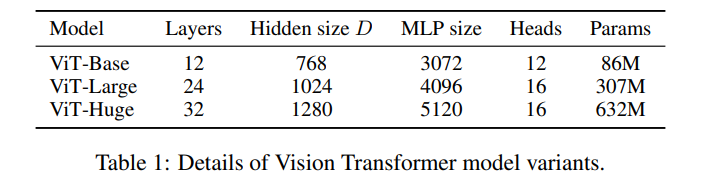

In [105]:
# ViT-B/16
v = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 768, # embedding 차원
    depth = 12, # Transformer layers
    heads = 12, # head 갯수
    mlp_dim = 3072, #
    dropout = 0.1,
    emb_dropout = 0.1
)
img = tf.random.normal(shape=[1, 224, 224, 3])
preds = v(img)
v.summary()

Model: "vi_t_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embedding (Sequential  (1, 196, 768)            593664    
 )                                                               
                                                                 
 dropout_876 (Dropout)       multiple                  0         
                                                                 
 transformer_36 (Transformer  multiple                 85026816  
 )                                                               
                                                                 
 mlp_head (Sequential)       (1, 1000)                 770536    
                                                                 
Total params: 86,543,080
Trainable params: 86,543,080
Non-trainable params: 0
_________________________________________________________________


In [107]:
# ViT-L/16
v = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 1024,
    depth = 24, 
    heads = 16, 
    mlp_dim = 4096,
    dropout = 0.1,
    emb_dropout = 0.1
)
img = tf.random.normal(shape=[1, 224, 224, 3])
preds = v(img)
v.summary()

Model: "vi_t_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embedding (Sequential  (1, 196, 1024)           791040    
 )                                                               
                                                                 
 dropout_986 (Dropout)       multiple                  0         
                                                                 
 transformer_38 (Transformer  multiple                 302235648 
 )                                                               
                                                                 
 mlp_head (Sequential)       (1, 1000)                 1027048   
                                                                 
Total params: 304,256,488
Trainable params: 304,256,488
Non-trainable params: 0
_________________________________________________________________


In [151]:
# ViT-H/14
v = ViT(
    image_size = 224,
    patch_size = 14,
    num_classes = 1000,
    dim = 1280,
    depth = 32, 
    heads = 16, 
    mlp_dim = 5120,
    dropout = 0.1,
    emb_dropout = 0.1
)
img = tf.random.normal(shape=[1, 224, 224, 3])
preds = v(img)
v.summary()

Model: "vi_t_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embedding (Sequential  (1, 256, 1280)           757656    
 )                                                               
                                                                 
 dropout_1253 (Dropout)      multiple                  0         
                                                                 
 transformer_41 (Transformer  multiple                 587612160 
 )                                                               
                                                                 
 mlp_head (Sequential)       (1, 1000)                 1283560   
                                                                 
Total params: 589,983,616
Trainable params: 589,983,616
Non-trainable params: 0
_________________________________________________________________


# Experiments
Pre-trained model 불러오기

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from vit_keras import vit, utils, visualize

In [101]:
# Load a model
image_size = 384
classes = utils.get_imagenet_classes()
model = vit.vit_b16(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=True
)
classes = utils.get_imagenet_classes()
model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 24, 24, 768)       590592    
                                                                 
 reshape_31 (Reshape)        (None, 576, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 577, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 577, 768)         443136    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 577, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

attention map 시각화해보기  
[visualize.py](https://github.com/faustomorales/vit-keras/blob/master/vit_keras/visualize.py)

In [112]:
urls = ['https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/South-western_black_rhinoceros_%28Diceros_bicornis_occidentalis%29_female.jpg/450px-South-western_black_rhinoceros_%28Diceros_bicornis_occidentalis%29_female.jpg',
'https://upload.wikimedia.org/wikipedia/commons/b/bc/Free%21_%283987584939%29.jpg',
'https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Equus_quagga_burchellii_-_Etosha%2C_2014.jpg/450px-Equus_quagga_burchellii_-_Etosha%2C_2014.jpg',
'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/Felis_silvestris_silvestris.jpg/260px-Felis_silvestris_silvestris.jpg',
'https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Lion_waiting_in_Namibia.jpg/400px-Lion_waiting_in_Namibia.jpg',
'https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Siberischer_tiger_de_edit02.jpg/400px-Siberischer_tiger_de_edit02.jpg']

Prediction: African elephant, Loxodonta africana


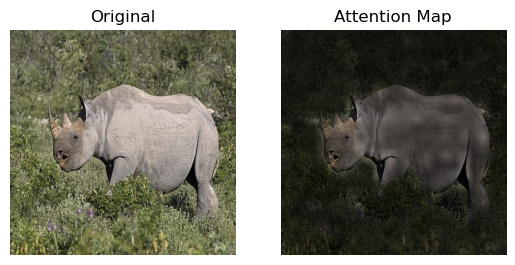

Prediction: Eskimo dog, husky


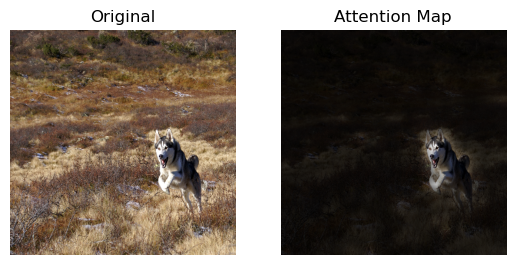

Prediction: zebra


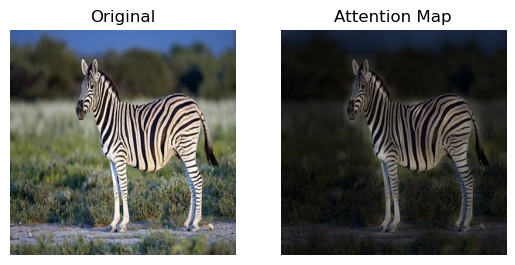

Prediction: tabby, tabby cat


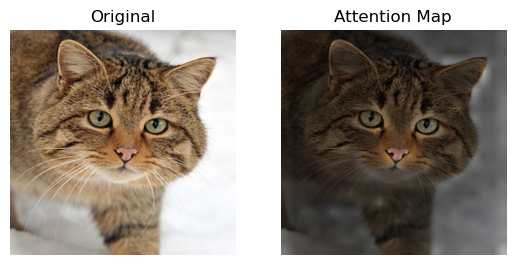

Prediction: lion, king of beasts, Panthera leo


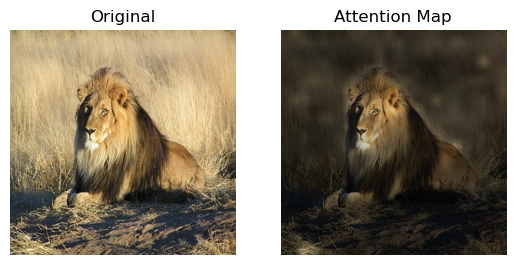

Prediction: tiger, Panthera tigris


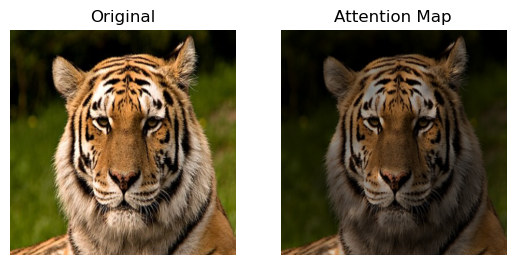

In [113]:
for url in urls:
    # Get an image and compute the attention map
    image = utils.read(url, image_size)
    attention_map = visualize.attention_map(model=model, image=image)
    print('Prediction:', classes[
        model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]
    ) 

    # Plot results
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(image)
    _ = ax2.imshow(attention_map)
    plt.show()

## Transfer learning
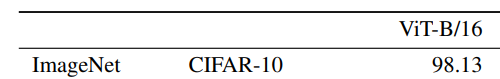
* For fine-tuning we use SGD with momentum
* All models are fine-tuned with cosine learning rate decay, a batch size of 512, no weight decay, and grad clipping at global norm 1

In [4]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import ResNet50

In [5]:
# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to the range [0, 1]
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Split the training set into training and validation sets
val_ratio = 0.1
num_val_samples = int(val_ratio * len(x_train_full))

x_val = x_train_full[:num_val_samples]
y_val = y_train_full[:num_val_samples]

x_train = x_train_full[num_val_samples:]
y_train = y_train_full[num_val_samples:]

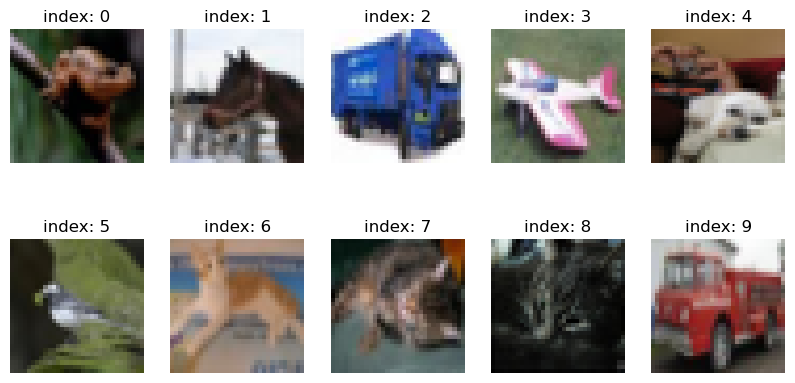

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [42]:
num_classes = 10
epochs = 300
warmup_epochs = 5
learning_rate = 1e-4
momentum = 0.9

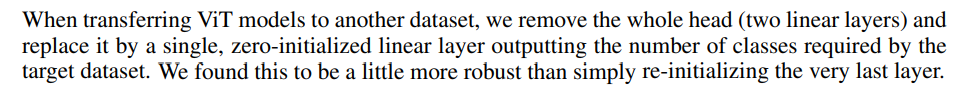

마지막단의 가중치를 모두 0으로 선언

## ResNet

In [46]:
# Load the pre-trained ResNet50 model with ImageNet weights excluding the top layer
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(32, 32, 3))

# Freeze the pre-trained layers
base_model.trainable = False

# Add a new fully connected top layer
inputs = tf.keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10 ,activation='softmax', kernel_initializer='zeros', bias_initializer='zeros')(x)

# Create the new model
model_res = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and high weight decay
optimizer1 = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, global_clipnorm=1)
model_res.compile(optimizer=optimizer1,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_res.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


## ViT

In [47]:
# Create the ViT model with pre-trained weights
model = vit.vit_b16(
    image_size=32,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

# Freeze the pre-trained layers
model.trainable = False

# Add a new fully connected top layer
inputs = tf.keras.Input(shape=(32, 32, 3))
x = model(inputs, training=False)
outputs = tf.keras.layers.Dense(10 ,activation='softmax', kernel_initializer='zeros', bias_initializer='zeros')(x)

# Create the new model
model_vit = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer and high weight decay
optimizer2 = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, global_clipnorm=1)
model_vit.compile(optimizer=optimizer2,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_vit.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85651200  
                                                                 
 dense_5 (Dense)             (None, 10)                7690      
                                                                 
Total params: 85,658,890
Trainable params: 7,690
Non-trainable params: 85,651,200
_________________________________________________________________


## Train

In [28]:
def lr_warmup_cosine_decay(epoch, warmup_epochs, hold, total_epochs, start_lr, target_lr):
    # Compute the learning rate based on the epoch
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (epoch - warmup_epochs - hold) / float(total_epochs - warmup_epochs - hold)))

    # Warmup phase
    if epoch < warmup_epochs:
        learning_rate = (epoch + 1) * start_lr / warmup_epochs

    return learning_rate

class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_epochs, total_epochs, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.hold = hold

    def __call__(self, epoch):
        lr = lr_warmup_cosine_decay(epoch, self.warmup_epochs, self.hold, self.total_epochs, self.start_lr, self.target_lr)
        return lr

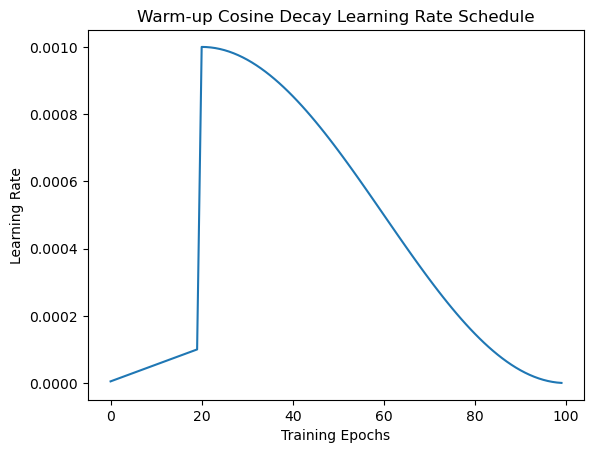

In [37]:
start_lr = 1e-4
target_lr = 1e-3
warmup_epochs = 20
total_epochs = 100
hold = 0

# Create an instance of the WarmUpCosineDecay learning rate schedule
lr_schedule = WarmUpCosineDecay(start_lr, target_lr, warmup_epochs, total_epochs, hold)

# Plot the learning rate over training steps
steps = range(total_epochs)
learning_rates = [lr_schedule(step) for step in steps]

plt.plot(steps, learning_rates)
plt.xlabel('Training Epochs')
plt.ylabel('Learning Rate')
plt.title('Warm-up Cosine Decay Learning Rate Schedule')
plt.show()

In [48]:
# Define the learning rate schedule
start_lr = 1e-4
target_lr = 1e-3
warmup_epochs = 30
total_epochs = 300
hold = 0

lr_schedule = WarmUpCosineDecay(start_lr, target_lr, warmup_epochs, total_epochs, hold)

schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [49]:
history1 = model_res.fit(x_train, y_train,
          batch_size=512,
          epochs=epochs,
          validation_data=(x_val, y_val),
          callbacks=[schedule])

Epoch 1/300
88/88 [==============================] - 3s 20ms/step - loss: 2.3026 - accuracy: 0.0988 - val_loss: 2.3025 - val_accuracy: 0.0920 - lr: 3.3333e-06
Epoch 2/300
88/88 [==============================] - 1s 14ms/step - loss: 2.3023 - accuracy: 0.1102 - val_loss: 2.3021 - val_accuracy: 0.1134 - lr: 6.6667e-06
Epoch 3/300
88/88 [==============================] - 1s 14ms/step - loss: 2.3020 - accuracy: 0.1126 - val_loss: 2.3016 - val_accuracy: 0.1678 - lr: 1.0000e-05
Epoch 4/300
88/88 [==============================] - 1s 14ms/step - loss: 2.3015 - accuracy: 0.1227 - val_loss: 2.3011 - val_accuracy: 0.0920 - lr: 1.3333e-05
Epoch 5/300
88/88 [==============================] - 1s 14ms/step - loss: 2.3007 - accuracy: 0.1130 - val_loss: 2.3002 - val_accuracy: 0.1298 - lr: 1.6667e-05
Epoch 6/300
88/88 [==============================] - 1s 14ms/step - loss: 2.2999 - accuracy: 0.1515 - val_loss: 2.2993 - val_accuracy: 0.2226 - lr: 2.0000e-05
Epoch 7/300
88/88 [===========================

In [ ]:
history2 = model_vit.fit(x_train, y_train,
          batch_size=512,
          epochs=epochs,
          validation_data=(x_val, y_val),
          callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/85
88/88 [==============================] - 9s 49ms/step - loss: 1.9541 - accuracy: 0.3195 - val_loss: 1.6859 - val_accuracy: 0.4052 - lr: 0.0020
Epoch 2/85
88/88 [==============================] - 3s 36ms/step - loss: 1.6021 - accuracy: 0.4364 - val_loss: 1.5547 - val_accuracy: 0.4590 - lr: 0.0040
Epoch 3/85
88/88 [==============================] - 3s 35ms/step - loss: 1.5369 - accuracy: 0.4574 - val_loss: 1.5588 - val_accuracy: 0.4530 - lr: 0.0060
Epoch 4/85
88/88 [==============================] - 3s 36ms/step - loss: 1.5323 - accuracy: 0.4616 - val_loss: 1.5445 - val_accuracy: 0.4670 - lr: 0.0080
Epoch 5/85
88/88 [==============================] - 3s 36ms/step - loss: 1.5503 - accuracy: 0.4590 - val_loss: 1.6021 - val_accuracy: 0.4522 - lr: 0.0100
Epoch 6/85
88/88 [==============================] - 3s 35ms/step - loss: 1.5358 - accuracy: 0.4645 - val_loss: 1.5561 - val_accuracy: 0.4640 - lr: 0.0100
Epoch 7/85
88/88 [==============================] - 3s 36ms/step - loss: 1.5

# 평가 & 시각화

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_res.evaluate(x_test, y_test, verbose=2)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 - 2s - loss: 1.5960 - accuracy: 0.4416 - 2s/epoch - 8ms/step
Test Loss: 1.5960075855255127
Test Accuracy: 0.4415999948978424


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_vit.evaluate(x_test, y_test, verbose=2)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 - 5s - loss: 1.5245 - accuracy: 0.4682 - 5s/epoch - 15ms/step
Test Loss: 1.5244665145874023
Test Accuracy: 0.4681999981403351


In [ ]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

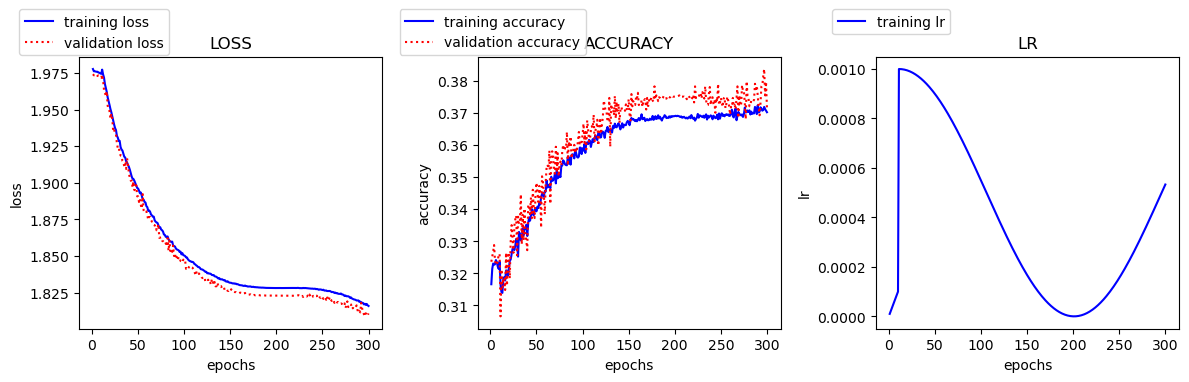

In [ ]:
plot_history(history1)

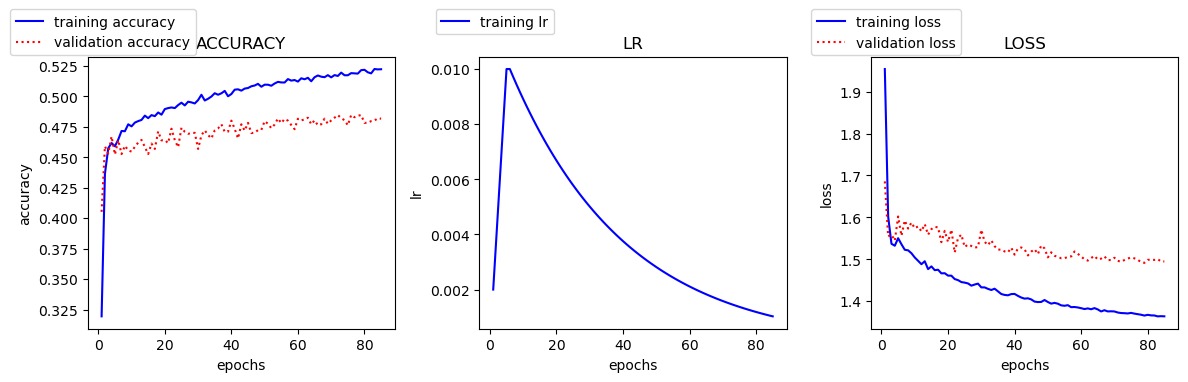

In [ ]:
plot_history(history2)

# Reference

1. https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
2. https://github.com/taki0112/vit-tensorflow/blob/main/vit_tensorflow/vit.py
3. https://visionhong.tistory.com/25